In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, Huber
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler

In [12]:
model_name = './cnn_less_nof2.keras'

In [4]:
foot_mat = loadmat('./JointLoad Data/foot_raw_clean.mat')
jointload_mat = loadmat('./JointLoad Data/jointload_raw_clean.mat')
angle_mat = loadmat('./JointLoad Data/angle_data.mat')

f1_foot_data = foot_mat['f1']
f2_foot_data = foot_mat['f2']
f3_foot_data = foot_mat['f3']

f1_jointload_data = jointload_mat['f1']
f2_jointload_data = jointload_mat['f2']
f3_jointload_data = jointload_mat['f3']

f1_angle_data = [np.interp(np.linspace(0, 1, 1000), np.linspace(0, 1, 30), i) for i in angle_mat['f1']]
f2_angle_data = [np.interp(np.linspace(0, 1, 1000), np.linspace(0, 1, 30), i) for i in angle_mat['f2']]
f3_angle_data = [np.interp(np.linspace(0, 1, 1000), np.linspace(0, 1, 30), i) for i in angle_mat['f3']]

foot_data = np.vstack((f1_foot_data, f2_foot_data, f3_foot_data))
angle_data = np.vstack((f1_angle_data, f2_angle_data, f3_angle_data))

scaler = StandardScaler()
standardized_foot_data = scaler.fit_transform(foot_data)
angle_scaler = StandardScaler()
standardized_angle_data = angle_scaler.fit_transform(angle_data)

f1_standardized_foot_data = standardized_foot_data[0:len(f1_foot_data)]
f2_standardized_foot_data = standardized_foot_data[len(f1_foot_data): len(f1_foot_data) + len(f2_foot_data)]
f3_standardized_foot_data = standardized_foot_data[len(f1_foot_data) + len(f2_foot_data):len(f1_foot_data) + len(f2_foot_data) + len(f3_foot_data)]
    
f1_standardized_angle_data = standardized_angle_data[0:len(f1_angle_data)]
f2_standardized_angle_data = standardized_angle_data[len(f1_angle_data): len(f1_angle_data) + len(f2_angle_data)]
f3_standardized_angle_data = standardized_angle_data[len(f1_angle_data) + len(f2_angle_data):len(f1_angle_data) + len(f2_angle_data) + len(f3_angle_data)]

print(len(f1_foot_data))
print(len(f2_foot_data))
print(len(f3_foot_data))

480
1766
1729


In [178]:
standardized_mat = loadmat('./JointLoad Data/standardized_data.mat')
standardized_data = standardized_mat['data']

In [5]:
# angle_data = f1_standardized_angle_data
# foot_data = f1_standardized_foot_data
# results = f1_jointload_data

angle_data = np.vstack((f1_standardized_angle_data, f2_standardized_angle_data, f3_standardized_angle_data))
foot_data = np.vstack((f1_standardized_foot_data, f2_standardized_foot_data, f3_standardized_foot_data))
results = np.vstack((f1_jointload_data, f2_jointload_data, f3_jointload_data))

data = np.stack((foot_data, angle_data), -1)
# data = standardized_data
print(np.shape(data))

(3975, 1000, 2)


In [13]:
loaded_model = load_model(model_name, compile= True)
loaded_model.summary()
# loaded_model.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=['mae'])

predictions = loaded_model.predict(data)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 998, 64)        │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 499, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 497, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 248, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 31744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │     2,031,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1000)           │       129,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,582,458 (25.11 MB)

 Trainable params: 2,194,152 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,388,306 (16.74 MB)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [14]:
def get_magnitudes(input_predictions):
    retVal = []
    for i in input_predictions:
        maximum = i[0]
        minimum = i[0]
        for j in i:
            if j > maximum:
                maximum = j
            elif j < minimum:
                minimum = j
        retVal.append((((maximum - minimum) * 1000 + .7367)/ 63.981) / (1.14 * (10 ** -5)) / 1000) 
    return retVal

def get_individual_distances(original, predicted):
    if len(original) != len(predicted):
        return -1
    retVal = np.zeros(len(original[0]))
    for i, j in zip(original, predicted):
        for n in range(len(original[0])):
            retVal[n] += i[n] - j[n]
    for n in range(len(retVal)):
        retVal[n] /= len(original)
    return retVal

In [15]:
mae = MeanAbsoluteError()
print("MAE: " + str(mae(results, predictions).numpy()))
mse = MeanSquaredError()
print("MSE: " + str(mse(results, predictions).numpy()))

MAE: 0.061283913
MSE: 0.008901654


(3975,)
(3975,)


Text(0.5, 0, 'Predicted Jointload Values (kPa)')

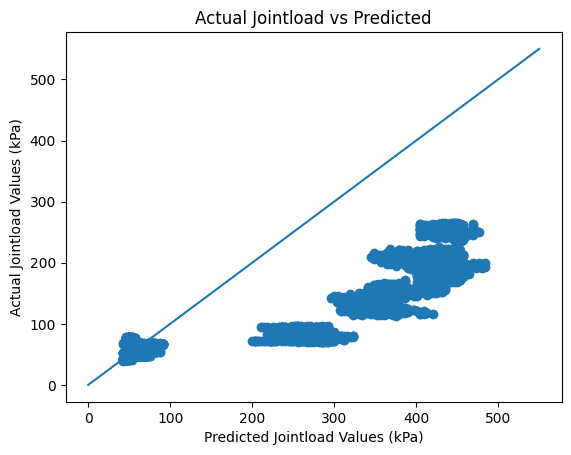

In [16]:
# Graph predicted vs actual
test_mags = get_magnitudes(results)
print(np.shape(test_mags))
predicted_mags = get_magnitudes(predictions)
print(np.shape(predicted_mags))
plt.scatter(test_mags, predicted_mags)
plt.plot(np.linspace(0, 550, 100), np.linspace(0, 550, 100))
plt.title("Actual Jointload vs Predicted")
plt.ylabel("Actual Jointload Values (kPa)")
plt.xlabel("Predicted Jointload Values (kPa)")

In [17]:
mae = MeanAbsoluteError()
print("MAE: " + str(mae(np.array(predicted_mags), np.array(test_mags)).numpy()))
mse = MeanSquaredError()
print("MSE: " + str(mse(np.array(predicted_mags), np.array(test_mags)).numpy()))

MAE: 119.44362
MSE: 24624.627


Text(0.5, 0, 'Time (Ms)')

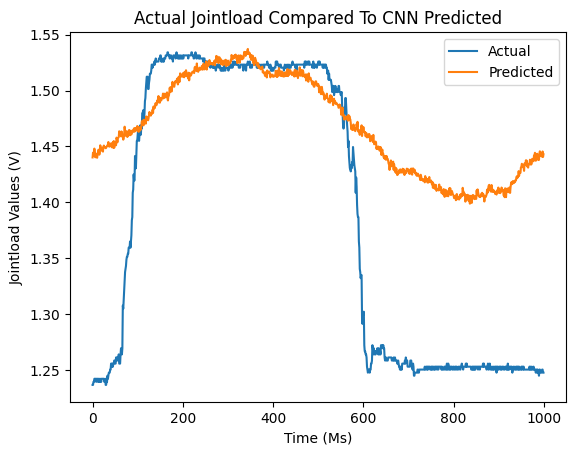

In [18]:
values = 2800
plt.plot(np.arange(0, 1000), results[values], label = 'Actual')
plt.plot(np.arange(0, 1000), predictions[values], label = 'Predicted')
plt.legend()
plt.title("Actual Jointload Compared To CNN Predicted")
plt.ylabel("Jointload Values (V)")
plt.xlabel("Time (Ms)")

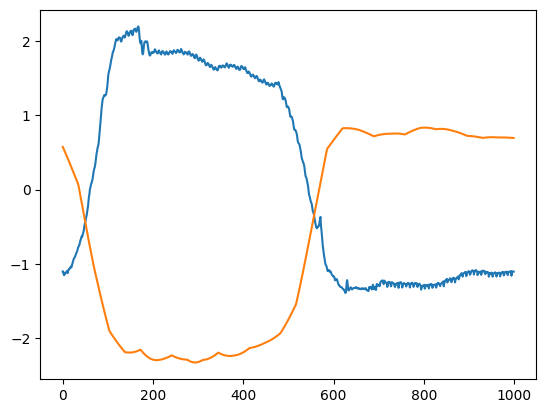

In [29]:
plt.plot(np.arange(0, 1000), data[values])

Text(0, 0.5, 'Average Difference')

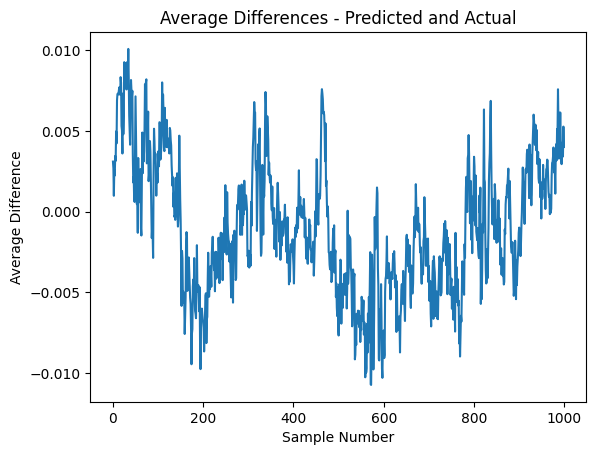

In [11]:
predicted_differences = get_individual_distances(results, predictions)
plt.plot(np.arange(0, 1000), predicted_differences)
plt.title("Average Differences - Predicted and Actual")
plt.xlabel("Sample Number")
plt.ylabel("Average Difference")